# Flooding stage 1 basin evolution - Western Mediterranean (wMed)

#### Here we compute the evolution of the mixing depth, mixed-layer salinity and density during the stage 1 of wMed flooding.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import pandas as pd
import gsw

## Upload data files here

In [3]:
KE           = np.loadtxt(fname="wMed_flow_KE.txt")           # Flow energy entering the wMed (From Script 1)
BPEad_wMed   = np.loadtxt(fname="wMed_added_BPE_Stage1.txt")  # Added BPE to wMed during stage 1 (From Script 2)
SLrise_wMed  = np.loadtxt(fname="SL_rise_wMed.txt")           # Rise of wMed level (From Script 1)
Discharge    = np.loadtxt(fname="Discharge.txt")              # Flow discharge (From Script 1)
Hypsometry_wMed = np.loadtxt(fname="Hypsometry_wMed_CalcBPE.txt")

## <span style='color:Red'> Concept  </span>

Consider the example below.
(A basin composed of 5 equal-thickness layers; L1 to L5)

A layer of sea-water containing a certain kinetic energy flows into the basin, creating a layer atop existing brines.
If available kinetic energy is suffiient to mix the sea-water with all the brine (down to L5), a single mixed fluid column will be formed.

If the available kinetic energy is insufficient for complete mixing, partial mixing will give a stratified basin.
In this example, inflow kinetic energy is sufficient only to mix the brines with sea-water down to L4.
The result is a mixed column of fluids down to L4, and a remaining layer of brine (L5).

Thus, L1 to L4 within which mixing occurs will be considered as a single system.

Initial Background potential energy(BPE) of the system is given by:
$$ BPE_{Initial}(L4) = BPE_{Added} + BPE_{Top} + BPE_{Cumulative}(L4) $$

Cumulative energy of the mixed fluids in all layers is given by $BPE_{Mixed}(L4)$

Inflow available kinetic energy ($KE_{Av}$)equals the difference between the mixed state and initial state energies.

$$ KE_{Av} = \Delta BPE = BPE_{Initial}(L4) - BPE_{Mixed}(L4)$$

 <img src="https://www.dropbox.com/s/3pk29f639oy4edj/mixing.jpg?raw=1">

## Setting parameters

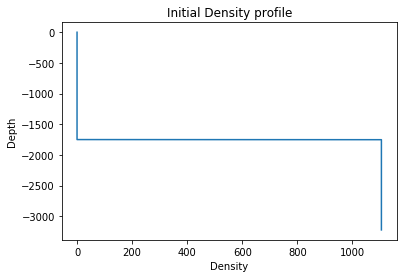

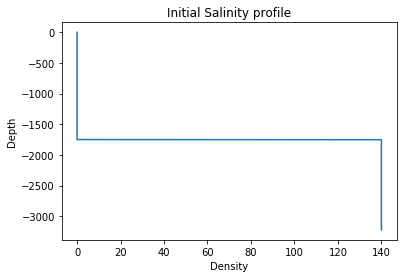

In [4]:
rho_SW   = 1027   # Inflowing sea-water density [kg m^-3]
S_Marine = 36.5   # Atlantic water salinity [PSU]
T_Brine  = 20     # Brine temperature [degrees Celcius]
g        = 9.81   # Acceleration due to gravity [m s^-2]
Mix_Ef   = 0.2    # Mixing efficiency

dzArray  = np.linspace(0.5,3223.5,3224)  # Creates an array of mid-layer depths

D_Brine = gsw.density.rho_t_exact ([140],[T_Brine],[0])  # Brine density [kg m^-3]

Depth     = Hypsometry_wMed[:,0]  # Reconstructed wMed hypsometry
DepthList = Depth.tolist()

Density   = np.where(Depth<1751,0,D_Brine)  # Creates the initial density profile of wMed
Salinity  = np.where(Depth<1751,0,140.0)    # Creates the initial salinity profile of wMed

Area       = (Hypsometry_wMed[:,1])*10**12    # Gives wMed area with depth from surface towards bottom
Vol_wMed   = (Hypsometry_wMed[:,3])*10**12    # Gives the cumulative volume in WMed from surface towards bottom
Volfrombot = (Hypsometry_wMed[:,2])*10**12    # Gives the cumulative volume in WMed from bottom towards surface

plt.figure()
plt.title('Initial Density profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(Density,-Depth)

plt.figure()
plt.title('Initial Salinity profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(Salinity,-Depth)


## <span style='color:Red'> Equations  </span>

### -Day 01 of wMed flooding-

### Calculating initial (before mixing) BPE :

Consider a drawn-down basin filled with a brine from a certain depth to the bottom. Assume that the basin is composed of 1-m thick layers as in the example.

If the top of the brine column **incompletely** fills a layer *(See the brine column in above diagram):*

Consider the thickness of layer of fluid in an incompletely filled top layer to be $dH_{wMed}$.
If the top of this fluid is set to base level $z = 0$ *(**important - heights measured above this level are positive, negative if below**)*,

BPE of the imcompletely filled layer is given by: $$ BPE_{Top} = - (\frac {dH_{wMed}}{2})^2 \times  (Area_{dH}) (\rho_{Brine}) g  $$
where $Area_{dH}$ is the area of the layer, $g$ is gravitational constant and $\rho_{Brine} $ is the brine density.

PE contribution by a complete single layer is given by: $$ BPE_{perCell} = - Area_{i} (\rho_{Brine})   (g) \times [(z_{i}-0.5)-SL_{wMed} ] {dz} $$

where $Area_i$ is the area of $i^{th}$ layer, $SL_{wMed}$ is the current sea-level, $z_i$ is the layer depth and $dz=1$ is the layer thickness.

Cumulative BPE of completely filled layers at each layer can be given as:

$$ BPE_{cumulative} = \sum_{i=1}^{n}BPE_{perCell} $$

Therefore, total initial BPE at the $n^{th}$ cell can be given by:
$$ BPEi_{Total}(n) = BPE_{Top}+\sum_{i=1}^{n}BPE_{perCell}+BPE_{Added} $$

where $BPE_{Added}$ is the daily added BPE by inflowing sea-water *(see the diagram above).*

### Calculating BPE after mixing:

To calculate the BPE after mixing, we need to know the salinity(density) of the mixed fluid. Salinity of the mixed fluid depends on the depth of mixing.

Depth to which mixing takes place depends on available kinetic energy ($KE_{Av}$) of the inflow.

Let's assume that mixing is limited down to the $n^{th}$ layer.

If the inflow volume of flood waters in day 1 = $Q_d$:

Salinity of the mixed fluid:
$$ S_{Mixed} = \frac {Q_d(\rho_{marine})+Q_{b^n}(\rho_{Brine})}{Q_d+Q_{b^n}} $$

where $\rho_{marine}$ is sea-water density and $Q_{b^n}$ is the brine volume at $n^{th}$ layer.

#### How the script works:

Goal of the script is to find the mixing depth and the salinity (density) of the mixed layer.
Mixing occurs if kinetic energy can overcome the energy difference between the mixed state and initial state energies ($\Delta BPE$).

For this, it is most convenient to calculate cumulative initial BPE and cumulative BPE after mixing at the bottom of each depth interval (each layer).
Thereby, resultant $\Delta BPE$ at each layer can be calculated. **($\Delta BPE$ increases with depth)**

Note that if the inflow KE is very less, only a few layers of brine will be mixed with sea-water. As kinetic energy increases, deeper layers can be mixed into the turbulent mixing layer. 
   
   As more layers of brine get mixed in, salinity of the mixed layer will increase. We calculated possible salinity with progressive downward mixing at each layer ($S_{Mixed}$)
   Maximum depth of the wMed is 3223 in our hypsometry. We fix initial drawdown to be 1750 m, this gives us 1473 layers of brine in the basin. 
   Assume that the minimum possible thickness of the mixed brine layer is 1 m (Mixing down to 1751 m).
   Therefore in Day 1, depending on the inflow KE, there are 1473 possibilities of mixing depths from 1 m to 1473 m below brine surface. 
  
  In following calculations, we consider all these possibilities of mixing by calculating BPE at each layer downwards.
  Finally, we compute the depth to the closest upper layer with $\Delta BPE$ less than $KE_{Av}$.
  This gives an answer for the mixing depth within an accuracy of 1 m. 
  

**1.** Initial cumulative BPE ($BPEi_{Total}$) can be calculated as discussed above, using initial density & salinity profiles. 

**Note** - $dH_{wMed} = 0$ *for the first day of flooding, as basin is filled with brines upto 1750 m from bottom.*

**2.** To calculate cumulative BPE  after mixing:

   **a)** To compute the salt content of a layer, we use wMed hypsometry. Total amount of salt in a single layer ($i$) is then    given by:
  $$ Sal\_Vol = V_i(S_{Brine}) $$
 
 where $V_i$ is the layer volume obtained from hypsometry, and $S_{Brine}$ is brine density.
 
 Therefore, total amount of salt existing above $n^{th}$  layer:
 $$Sal Vol\_cumulative = \sum_{i=1}^{n} V_i(S_{Brine})$$
 
 Then the salinity after mixing is:
 
 $$ S_{Mixed} = \frac {Q_d(\rho_{marine})+SalVol\_cumulative + [Vol_{dH}(\rho_{Brine})]}{(Q_d + Vol\_cumulative + Vol_{dH})} $$
 
 where $Vol_{dH}$ is the volume of the incompletely filled top layer and $Vol\_cumulative$ is the total volume of brine in  completely filled cells above $n^{th}$ layer.
 
 This way, we calculate possible salinity (thereby, density) of mixed layer during downward mixing at each 1-m depth interval.

   **b)** Then, to calculate BPE after mixing ($BPE_{Mixed}$) at each layer, consider the diagram below
    
    
    
<img src="https://www.dropbox.com/s/hwona3gieauptxc/mixed_BPE%20layers.jpg?raw=1" width="603.4" height="177.1">
    
   
   
   BPE of the layer in top incompletely filled cell : $$ BPE\_Top_{(Mixed)} = - (\frac {dH_{wMed}}{2})^2 \times  (A_{1}) (\rho_{Mixed}) g  $$
   
   where $A_{1}$ is the area of the layer and $\rho_{Mixed} $ is the Mixed layer density.
   
   PE contribution by a complete single layer is given by: $$ BPE\_perCell_{(Mixed)} = - A_{i} (\rho_{Mixed})   (g) \times [(z_{i}-0.5) - SL_{wMed}]  {dz} $$
   
   where $A_i$ is the area of $i^{th}$ layer, $SL_{wMed}$ is the current sea-level, $z_i$ is the layer depth and $dz=1$ is the layer thickness.
   
   Therefore, total BPE at bottom of each layer can be written as....
   
   * <font size="2">$BPE\_cumulative_{Mixed(L2)} = BPE\_Top_{(Mixed)} + [A_2(\rho_{Mixed}) g [(1.5 dz)-SL_{wMed}]  {dz}]$</font>
   * <font size="2">$BPE\_cumulative_{Mixed(L3)} = BPE\_Top_{(Mixed)} + [A_2(\rho_{Mixed}) g [(1.5 dz)-SL_{wMed}]  {dz}] + [A_3(\rho_{Mixed}) g [(2.5 dz)-SL_{wMed}]  {dz}]$</font>
   * <font size="2">$BPE\_cumulative_{Mixed(L4)} = BPE\_Top_{(Mixed)} + [A_2(\rho_{Mixed}) g [(1.5 dz)-SL_{wMed}]  {dz}]+ [A_3(\rho_{Mixed}) g [(2.5 dz)-SL_{wMed}]  {dz}]+ [A_4(\rho_{Mixed}) g [(3.5 dz)-SL_{wMed}]  {dz}]$</font>
   
   In each of the expression, when common parameters are factored out, the product of area and mid-layer depth of the layers can be isolated.
   Therefore, we create an array of cumulative (${Layer}\ {area} \times mid\ layer\ depth$) terms *(see the script)*:
   
   
   * $ Product\_AreaHt = -[(z_i-0.5)-SL_{wMed}]\times A_i$
   * $ Product\_cumulative = -\sum_{i=1}^{n} Product\_AreaHt$
   
   Then, expected total $BPE_{Mixed}$ at each layer during downward mixing can be given as:
   
   $$BPE_{Mixed} = BPE\_Added_{(Mixed)}+ BPE\_Top_{(Mixed)} + [(Product\_cumulative(\rho_{Mixed})g (dz)] $$
   
   Here, $BPE\_Added_{(Mixed)}$ and $BPE\_Top_{(Mixed)}$ can be obtained by multiplying $BPE_{Added}$ and $BPE_{Top}$ by after  and before-mixing density ratios *(see the script)*.
   
**3.** Now, we can use answers from **1 and 2** to calculate $\Delta BPE$ of progressive downward mixing at each layer.
   
   By taking the differences of the arrays, $\Delta BPE$ at the $n^{th}$ layer is given by:
   
   $$ \Delta BPE(n) =  BPE_{Mixed}(n)- BPEi_{Total}(n)  $$
   
   As long as $\Delta BPE$ is less than $KE_{Av}$, brines will be mixed into the mixed layer.
   
  <font size="3">**-End of Day 01-**</font>
  
  At the end of day 01, we can obtain the salinity/density profile of the wMed. Now the basin cosists of a mixed layer at the top, and residual brines below.
  
  This profile is then used to calculate mixing parameters in the following days.
  
  Note that in **initial BPE equations**, $\rho_{Brine}$ will be replaced by $\rho_{Mixed}$ where the mixed fluid exists.

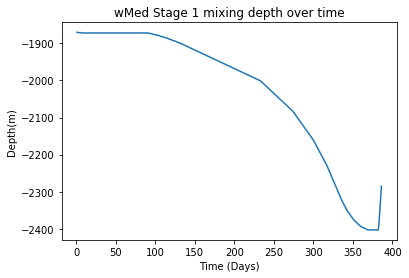

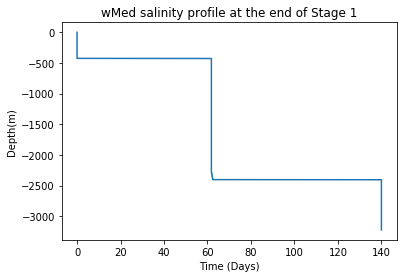

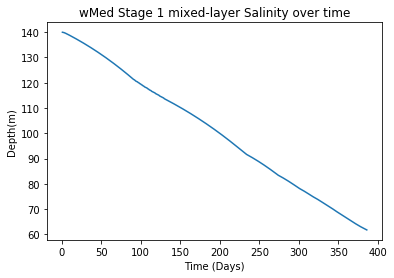

In [7]:
t = 1  # Starting time   
SLtruncated_wMed = np.trunc(SLrise_wMed)  # truncated values of sea-level
KEAv = KE*(Mix_Ef)  # Available kinetic energy

# Setting arrays used for calculations and plotting

SLArray      = [1751]   # A value set to 1 meter greater than initial WMed to initiate the program
MixedD_wMed  = [0]      # Initial mixied layer density (No mixed layer at the beginning)
MixedS_wMed  = [0]      # Initial mixied layer salinity (No mixed layer at the beginning)
Mdepth_wMed  = []       # Appends daily mixing depth [m]
Times        = []       # Appends time [days]
D_profile    = []       # Appends final density profile at the end of stage 1
S_profile    = []       # Appends final salinity profile at the end of stage 1

# SALINITY AND DENSITY PROFILES REPEATED HERE TO AVOID UPDATING OF THE PROFILES DURING LOOPING
Density   = np.where(Depth<1751,0,D_Brine)  # Initial density profile of wMed
Salinity  = np.where(Depth<1751,0,140.0)    # Initial salinity profile of wMed

# WMed basin is considered to be 3223 m deep, composed of 3223 1 m-thick layers

while t<387:
    
    empty_VolwMed = Vol_wMed[(int(SLtruncated_wMed[t-1]))] # empty_VolwMed is the total volume of the empty space above basin surface,
                                                           # as it rises due to inflowing sea water

    SLwMed    = SLrise_wMed[t-1]         # True sea level  (Daily sea level) of the PREVIOUS day
    SLArray.append(SLwMed)
    SLtWMed   = int(SLtruncated_wMed[t]) # Truncated sea level at a given time

    AddedBPE_daily = BPEad_wMed[t-1]          # Total BPE of the daily added sea water layer
    Dis_daily      = Discharge[t]*3600*24     # Daily discharge
    
    #print (AddedBPE_daily)
    
    dH_wMed = (SLtWMed+1)-(SLArray[-1])  # thickness of water layer in the top incompletely-filled layer
    Area_dH = (Area[SLtWMed+1])          # area of the top incompletely-filled layer
    Vol_dH  = dH_wMed*Area_dH            # Volume of fluids in top incompletely-filled layer
    
    #print ( dH_wMed,Area_dH)
    
    # Emptying all the arrays in the loop to keep the script running
    
    MixD_wMed         = []  
    Product_AreaHt    = []
    BPE_perCell       = []
    delta_BPE         = []
    Depth_List        = []
    Mixed_DList       = []
    MixingDepth_wMed  = []
    BPE_mixed         = []
    D_MixedLayer      = []
    index_a           = []
    index_b           = []
    Sal_Vol           = []
    SalVol_cumulative = []
    Mixed_Sal         = []
    BPEi_TotalwMed    = []
    BPE_Top           = []
    Mixed_D           = []
    MixDlist          = []
    
    # Following 4 lines calculate the initial BPE profile (Cumulative)

    BPE_perCell    = -(Area*Density*g*(Depth-(SLwMed-0.5))) # Initial BPE of completely filled layers
    
    BPE_cumulative = np.cumsum(BPE_perCell)  # cumulative of initial BPE at each layer downwards
    
    BPE_Top        = ((dH_wMed/2)**2)*(Area_dH)*(MixedD_wMed[-1])*g  # BPE of the top incompletely filled layer
    
    BPEi_TotalwMed = np.where(BPE_cumulative!=0.0, BPE_cumulative + AddedBPE_daily - BPE_Top,0.0)  # Total initial BPE at each layer
    
    # Following 9 lines calculate the BPE after mixing (Cumulative)
    
    Sal_Vol           = np.where(Salinity!=0, (Salinity*(Area)),0)  # Computes total salt content of each layer
    SalVol_cumulative = np.cumsum(Sal_Vol)  
    
    
    # Computes possible mixed salinity during progressive downward mixing at each layer
    Mixed_Sal = np.where(Salinity!=0,((Dis_daily*S_Marine) + SalVol_cumulative + (Vol_dH*(MixedS_wMed[-1])))/(Dis_daily + (Vol_wMed - empty_VolwMed)+Vol_dH),0.0)
    
    Mixed_Sal = Mixed_Sal.tolist()
    
    # Converts salinity to density using GSW Function
    Mixed_D   = np.where(Salinity!=0, (gsw.density.rho_t_exact ([Mixed_Sal],[T_Brine],[0])),0.0)

    MixD_wMed = np.array(Mixed_D).flatten()
   
    # product of layer area and mid-layer depth (see explanation)
    Product_AreaHt     = np.where(MixD_wMed!=0,(dzArray - SLwMed)*Area,0)
    Product_cumulative = np.cumsum(Product_AreaHt)
    
    # BPE after mixing for all possibilities of mixing
    BPE_mixed = np.where(MixD_wMed!=0,-(MixD_wMed*(Product_cumulative-Product_cumulative[SLtWMed])*g)+(AddedBPE_daily*(MixD_wMed/rho_SW))+(-BPE_Top *(MixD_wMed/rho_SW)) ,0)

    # dBPE for all possibilities of mixing
    delta_BPE = (np.subtract(BPE_mixed,BPEi_TotalwMed))# PROFILE of the change in BPE at each 1 meter level below surface
    delta_BPE = np.array(delta_BPE).flatten()

    #print (BPEi_TotalwMed)
    #print (delta_BPE)

    
    for i,j,j0 in zip(delta_BPE, Depth, MixD_wMed): # To calculate the mixing depth to the closest upper layer bottom.
    
        if i<(KEAv[t]):
            Depth_List.append(j)
            Mixed_DList.append(j0)
        
    MixingDepth_wMed  = np.max(Depth_List)  # Daily mixing depth [m]
    D_MixedLayer      = np.max(Mixed_DList) # Mixed layer density [kg^m-3]
    
    D_index = np.where(MixD_wMed == D_MixedLayer)
    Dind = (D_index[0])
    Dind = int(Dind)

    S_MixedLayer = Mixed_Sal[Dind]    # Mixed layer salinity
    MixedD_wMed.append(D_MixedLayer)  # For plotting
    MixedS_wMed.append(S_MixedLayer)  # For plotting
    
    #print ('Lower limit of the mixed layer is',MixingDepth_wMed,'meters') 
    #print ('Thickness of the mixed layer is',(MixingDepth_wMed-SLwMed),'meters') 
    #print ('Density of the mixed layer is',D_MixedLayer, S_MixedLayer) 
    #print(KE[t])

    index_a = DepthList.index(SLtWMed+1)
    
    if MixingDepth_wMed == 3223:
        index_b = DepthList.index(MixingDepth_wMed)
    else:
        index_b = DepthList.index(MixingDepth_wMed+1)
    
   
    # Updating the density and salinity profiles after mixing 
    Density2 = Density
    Density2[index_a:index_b]= D_MixedLayer
    
    Density = Density2
    
    Salinity2 = Salinity
    Salinity2[index_a:index_b]= S_MixedLayer
    
    Salinity = Salinity2

    #print (t,SLwMed)
    
    Mdepth_wMed.append(-MixingDepth_wMed)  
    Times.append(t)
    
    t=t+1  # Moving in to the next day
    
    if t%100 == 0:  # Use this to save salinity profile at 100-day intervals
        
        filename = 'Profile_%06d.txt'%t
        #print('NOW',filename)
        #np.savetxt(filename,Salinity,fmt="%s")
  
S_profile.append(Salinity)
D_profile.append(Density)
Sprofile_final = Salinity.tolist()
Dprofile_final = Density.tolist()

#print (MixedS_wMed)

np.savetxt("wMed_SprofileStage1-20.txt", np.array(Sprofile_final), fmt="%s")
np.savetxt("wMed_DprofileStage1-20.txt", np.array(Dprofile_final), fmt="%s")
#np.savetxt("MdepthStage1-20.txt", np.array(Mdepth_wMed), fmt="%s")
#np.savetxt("Time S1.txt", np.array(Times))
#np.savetxt("Salinity with time S1-20.txt", np.array(MixedS_wMed))

plt.figure()
plt.title ('wMed Stage 1 mixing depth over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,Mdepth_wMed)
plt.figure()
plt.title ('wMed salinity profile at the end of Stage 1')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Salinity,-(Depth))
plt.figure()
plt.title ('wMed Stage 1 mixed-layer Salinity over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,MixedS_wMed[1:])